<h1><center>How to export 🤗 Transformers Models to ONNX ?<h1><center>

[ONNX](http://onnx.ai/) is open format for machine learning models. It allows to save your neural network's computation graph in a framework agnostic way, which might be particulary helpful when deploying deep learning models.

Indeed, businesses might have other requirements _(languages, hardware, ...)_ for which the training framework might not be the best suited in inference scenarios. In that context, having a representation of the actual computation graph that can be shared accross various business units and logics across an organization might be a desirable component.

Along with the serialization format, ONNX also provides a runtime library which allows efficient and hardware specific execution of the ONNX graph. This is done through the [onnxruntime](https://microsoft.github.io/onnxruntime/) project and already includes collaborations with many hardware vendors to seamlessly deploy models on various platforms.

Through this notebook we'll walk you through the process to convert a PyTorch or TensorFlow transformers model to the [ONNX](http://onnx.ai/) and leverage [onnxruntime](https://microsoft.github.io/onnxruntime/) to run inference tasks on models from  🤗 __transformers__

## Exporting 🤗 transformers model to ONNX

---

Exporting models _(either PyTorch or TensorFlow)_ is easily achieved through the conversion tool provided as part of 🤗 __transformers__ repository. 

Under the hood the process is sensibly the following: 

1. Allocate the model from transformers (**PyTorch or TensorFlow**)
2. Forward dummy inputs through the model this way **ONNX** can record the set of operations executed
3. Optionally define dynamic axes on input and output tensors
4. Save the graph along with the network parameters

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade git+https://github.com/huggingface/transformers
!{sys.executable} -m pip install --upgrade torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!{sys.executable} -m pip install --upgrade onnxruntime==1.4.0
!{sys.executable} -m pip install -i https://test.pypi.org/simple/ ort-nightly
!{sys.executable} -m pip install --upgrade onnxruntime-tools

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-9rvbp9p8
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-9rvbp9p8
  Created wheel for transformers: filename=transformers-3.0.2-py3-none-any.whl size=883063 sha256=5f2caef76450921ae2e5b10abbbaab436e9c87c83486114fa08d305e4396d4cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-kftypcjz/wheels/42/68/45/c63edff61c292f2dfd4df4ef6522dcbecc603e7af82813c1d7
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.6.0+cpu in /home/mfuntowicz/miniconda3/envs/pytorch/lib/python3.8/site-packages (1.6.0+cpu)
Requirement already up-to-date: torchvision==0.7.0+cpu in /home/mfuntowicz/miniconda3/envs/pytorch/lib/python3.8/

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [1]:
from transformers.utils import send_example_telemetry

send_example_telemetry("onnx_export_notebook", framework="pytorch")

/Users/es.py/Projects/Personal/masakhane-web/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!rm -rf onnx/
from pathlib import Path
from transformers.convert_graph_to_onnx import convert

# Handles all the above steps for you
convert(framework="pt", model="bert-base-cased", output=Path("onnx/bert-base-cased.onnx"), opset=11)

# Tensorflow 
# convert(framework="tf", model="bert-base-cased", output="onnx/bert-base-cased.onnx", opset=11)

/Users/es.py/Projects/Personal/masakhane-web/.venv/lib/python3.10/site-packages/transformers/convert_graph_to_onnx.py:380: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 11
Loading pipeline (model: bert-base-cased, tokenizer: bert-base-cased)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Creating folder onnx
Using framework PyTorch: 1.13.1
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']


## How to leverage runtime for inference over an ONNX graph

---

As mentionned in the introduction, **ONNX** is a serialization format and many side projects can load the saved graph and run the actual computations from it. Here, we'll focus on the official [onnxruntime](https://microsoft.github.io/onnxruntime/). The runtime is implemented in C++ for performance reasons and provides API/Bindings for C++, C, C#, Java and Python.

In the case of this notebook, we will use the Python API to highlight how to load a serialized **ONNX** graph and run inference workload on various backends through **onnxruntime**.

**onnxruntime** is available on pypi:

- onnxruntime: ONNX + MLAS (Microsoft Linear Algebra Subprograms)
- onnxruntime-gpu: ONNX + MLAS + CUDA


In [5]:
!pip install transformers onnxruntime onnx psutil matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Preparing for an Inference Session

---

Inference is done using a specific backend definition which turns on hardware specific optimizations of the graph. 

Optimizations are basically of three kinds: 

- **Constant Folding**: Convert static variables to constants in the graph 
- **Deadcode Elimination**: Remove nodes never accessed in the graph
- **Operator Fusing**: Merge multiple instruction into one (Linear -> ReLU can be fused to be LinearReLU)

ONNX Runtime automatically applies most optimizations by setting specific `SessionOptions`.

Note:Some of the latest optimizations that are not yet integrated into ONNX Runtime are available in [optimization script](https://github.com/microsoft/onnxruntime/tree/master/onnxruntime/python/tools/transformers) that tunes models for the best performance.

In [3]:
from onnxruntime.transformers import optimizer


optimized_model = optimizer.optimize_model('onnx/bert-base-cased.onnx', model_type='bert', num_heads=12, hidden_size=768)
optimized_model.save_model_to_file('bert.opt.onnx')


In [4]:
from os import environ
from psutil import cpu_count

# Constants from the performance optimization available in onnxruntime
# It needs to be done before importing onnxruntime
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

In [5]:
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties that might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

  # Load the model as a graph and prepare the CPU backend 
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()
    
  return session


@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

## Forwarding through our optimized ONNX model running on CPU

---

When the model is loaded for inference over a specific provider, for instance **CPUExecutionProvider** as above, an optimized graph can be saved. This graph will might include various optimizations, and you might be able to see some **higher-level** operations in the graph _(through [Netron](https://github.com/lutzroeder/Netron) for instance)_ such as:
- **EmbedLayerNormalization**
- **Attention**
- **FastGeLU**

These operations are an example of the kind of optimization **onnxruntime** is doing, for instance here gathering multiple operations into bigger one _(Operator Fusing)_.

In [6]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
cpu_model = create_model_for_provider("onnx/bert-base-cased.onnx", "CPUExecutionProvider")

# Inputs are provided through numpy array
model_inputs = tokenizer("My name is Bert", return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

# Run the model (None = get all the outputs)
sequence, pooled = cpu_model.run(None, inputs_onnx)

# Print information about outputs

print(f"Sequence output: {sequence.shape}, Pooled output: {pooled.shape}")

Sequence output: (1, 6, 768), Pooled output: (1, 768)


# Benchmarking PyTorch model

_Note: PyTorch model benchmark is run on CPU_

In [7]:
from transformers import BertModel

PROVIDERS = {
    ("cpu", "PyTorch CPU"),
#  Uncomment this line to enable GPU benchmarking
#    ("cuda:0", "PyTorch GPU")
}

results = {}

for device, label in PROVIDERS:
    
    # Move inputs to the correct device
    model_inputs_on_device = {
        arg_name: tensor.to(device)
        for arg_name, tensor in model_inputs.items()
    }

    # Add PyTorch to the providers
    model_pt = BertModel.from_pretrained("bert-base-cased").to(device)
    for _ in trange(10, desc="Warming up"):
      model_pt(**model_inputs_on_device)

    # Compute 
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
      with track_infer_time(time_buffer):
        model_pt(**model_inputs_on_device)

    # Store the result
    results[label] = OnnxInferenceResult(
        time_buffer, 
        None
    ) 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tracking inference time on PyTorch: 100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


## Benchmarking PyTorch & ONNX on CPU

_**Disclamer: results may vary from the actual hardware used to run the model**_

In [8]:
PROVIDERS = {
    ("CPUExecutionProvider", "ONNX CPU"),
#  Uncomment this line to enable GPU benchmarking
#     ("CUDAExecutionProvider", "ONNX GPU")
}


for provider, label in PROVIDERS:
    # Create the model with the specified provider
    model = create_model_for_provider("onnx/bert-base-cased.onnx", provider)

    # Keep track of the inference time
    time_buffer = []

    # Warm up the model
    model.run(None, inputs_onnx)

    # Compute 
    for _ in trange(100, desc=f"Tracking inference time on {provider}"):
      with track_infer_time(time_buffer):
          model.run(None, inputs_onnx)

    # Store the result
    results[label] = OnnxInferenceResult(
      time_buffer,
      model.get_session_options().optimized_model_filepath
    )

Tracking inference time on CPUExecutionProvider: 100%|██████████| 100/100 [00:02<00:00, 36.48it/s]


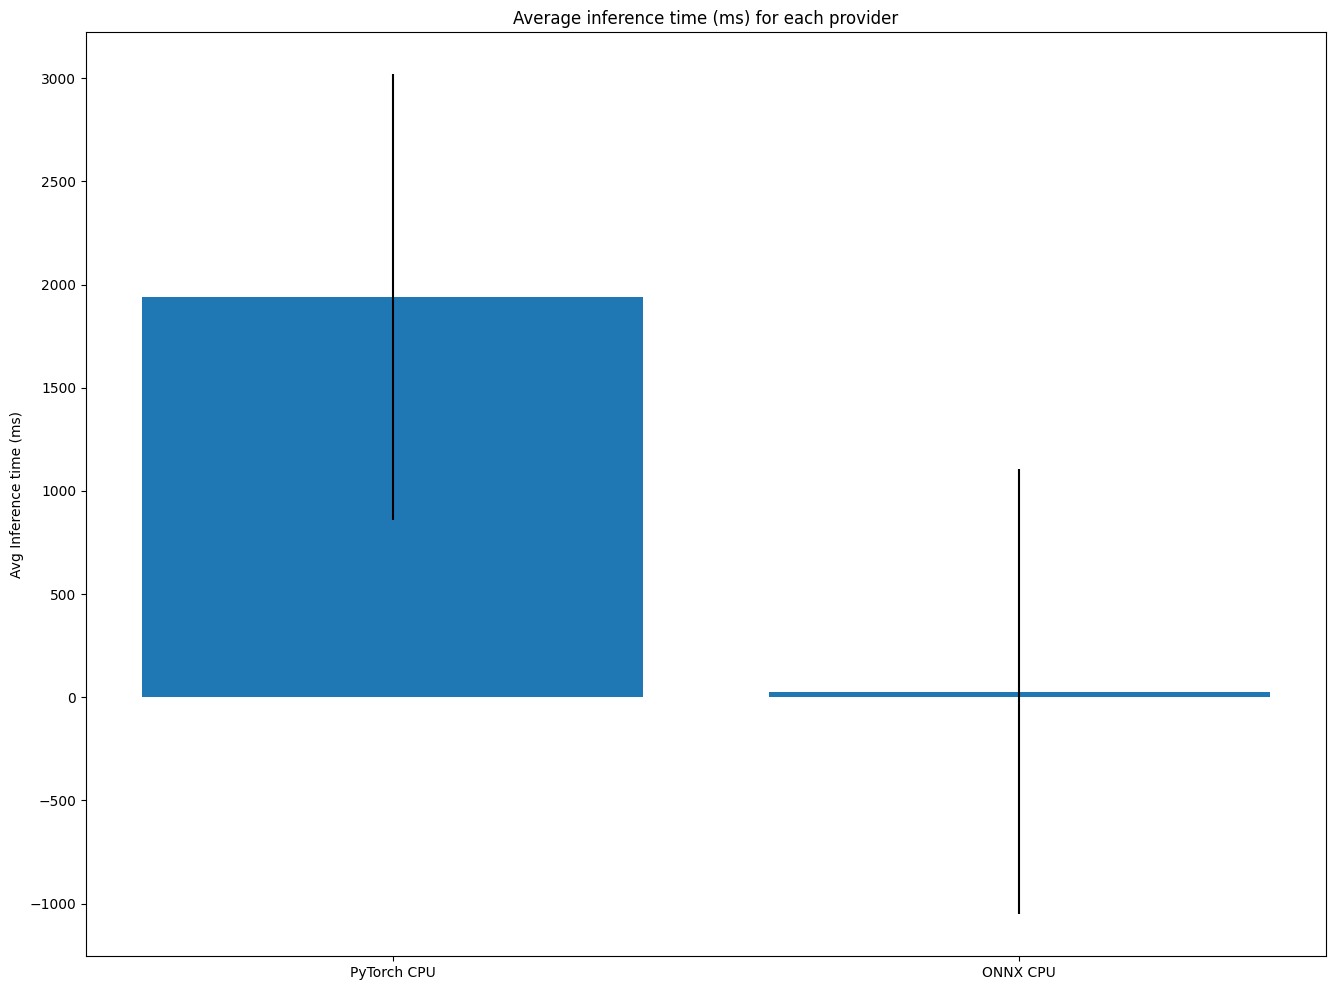

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()

# Quantization support from transformers

Quantization enables the use of integers (_instead of floatting point_) arithmetic to run neural networks models faster. From a high-level point of view, quantization works as mapping the float32 ranges of values as int8 with the less loss in the performances of the model.

Hugging Face provides a conversion tool as part of the transformers repository to easily export quantized models to ONNX Runtime. For more information, please refer to the following: 

- [Hugging Face Documentation on ONNX Runtime quantization supports](https://huggingface.co/transformers/master/serialization.html#quantization)
- [Intel's Explanation of Quantization](https://nervanasystems.github.io/distiller/quantization.html)

With this method, the accuracy of the model remains at the same level than the full-precision model. If you want to see benchmarks on model performances, we recommand reading the [ONNX Runtime notebook](https://github.com/microsoft/onnxruntime/blob/master/onnxruntime/python/tools/quantization/notebooks/Bert-GLUE_OnnxRuntime_quantization.ipynb) on the subject.

# Benchmarking PyTorch quantized model

In [ ]:
import torch 

# Quantize
model_pt_quantized = torch.quantization.quantize_dynamic(
    model_pt.to("cpu"), {torch.nn.Linear}, dtype=torch.qint8
)

# Warm up 
model_pt_quantized(**model_inputs)

# Benchmark PyTorch quantized model
time_buffer = []
for _ in trange(100):
    with track_infer_time(time_buffer):
        model_pt_quantized(**model_inputs)
    
results["PyTorch CPU Quantized"] = OnnxInferenceResult(
    time_buffer,
    None
)

100%|██████████| 100/100 [00:01<00:00, 90.15it/s]


# Benchmarking ONNX quantized model

In [ ]:
from transformers.convert_graph_to_onnx import quantize

# Transformers allow you to easily convert float32 model to quantized int8 with ONNX Runtime
quantized_model_path = quantize(Path("bert.opt.onnx"))

# Then you just have to load through ONNX runtime as you would normally do
quantized_model = create_model_for_provider(quantized_model_path.as_posix(), "CPUExecutionProvider")

# Warm up the overall model to have a fair comparaison
outputs = quantized_model.run(None, inputs_onnx)

# Evaluate performances
time_buffer = []
for _ in trange(100, desc=f"Tracking inference time on CPUExecutionProvider with quantized model"):
    with track_infer_time(time_buffer):
        outputs = quantized_model.run(None, inputs_onnx)

# Store the result
results["ONNX CPU Quantized"] = OnnxInferenceResult(
    time_buffer, 
    quantized_model_path
) 

As of onnxruntime 1.4.0, models larger than 2GB will fail to quantize due to protobuf constraint.
This limitation will be removed in the next release of onnxruntime.
Quantized model has been written at bert.onnx: ✔


Tracking inference time on CPUExecutionProvider with quantized model: 100%|██████████| 100/100 [00:00<00:00, 237.49it/s]


## Show the inference performance of each providers 

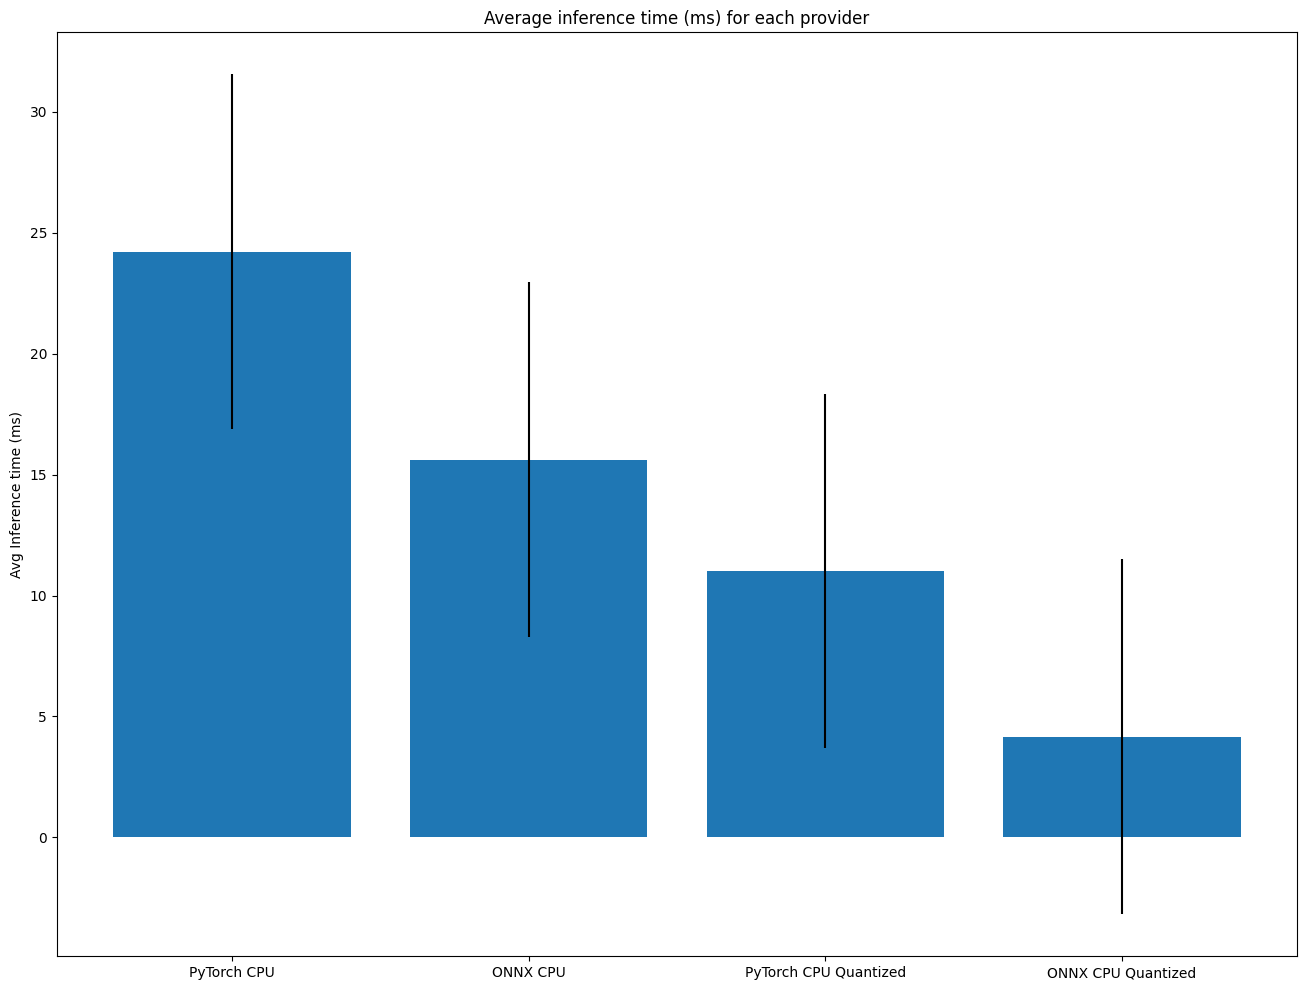

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()